In [10]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
mean = (0.5071, 0.4867, 0.4408)
std = (0.2675, 0.2565, 0.2761)
data_transforms = {
    # 訓練資料集採用資料增強與標準化轉換
    'train': transforms.Compose([
  #      transforms.RandomResizedCrop(224), # 隨機剪裁並縮放
        transforms.RandomHorizontalFlip(), # 隨機水平翻轉
        transforms.ToTensor(),
        transforms.Normalize(mean, std) # 標準化
    ]),
    # 驗證資料集僅採用資料標準化轉換
    'val': transforms.Compose([
        # transforms.Resize(256),  # 縮放
       #  transforms.CenterCrop(224), # 中央剪裁
        transforms.ToTensor(),
        transforms.Normalize(mean, std) # 標準化
    ]),
}

In [12]:
batch_size = 32
num_classes = 100 
data_dir = 'data/hymenoptera_data'
trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=data_transforms['train'])

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=data_transforms['val'])

dataloaders = {'train':torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2),
                'val':torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=True, num_workers=2)}

dataset_sizes ={'train':50000, 'val':10000}
print(dataset_sizes)

Files already downloaded and verified
Files already downloaded and verified
{'train': 50000, 'val': 10000}


In [13]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time() # 記錄開始時間
    save_path = './model.pth'
    # 記錄最佳模型
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # 訓練模型主迴圈
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 對於每個 epoch，分別進行訓練模型與驗證模型
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 將模型設定為訓練模式
            else:
                model.eval()   # 將模型設定為驗證模式

            running_loss = 0.0
            running_corrects = 0

            # 以 DataLoader 載入 batch 資料
            for inputs, labels in dataloaders[phase]:
                # 將資料放置於 GPU 或 CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 重設參數梯度（gradient）
                optimizer.zero_grad()

                # 只在訓練模式計算參數梯度
                with torch.set_grad_enabled(phase == 'train'):
                    # 正向傳播（forward）
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
        
                    if phase == 'train':
                        loss.backward()  # 反向傳播（backward）
                        optimizer.step() # 更新參數

                # 計算統計值
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                # 更新 scheduler
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            elif phase == 'val':
                test_loss.append(epoch_loss)
                test_acc.append(epoch_acc)
            # 記錄最佳模型
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model, './best.pth')
        torch.save(model, save_path)
        print()
    # 計算耗費時間
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # 輸出最佳準確度
    print('Best val Acc: {:4f}'.format(best_acc))

    # 載入最佳模型參數
    model.load_state_dict(best_model_wts)
    return model

In [15]:
dataaugu = torch.nn.Sequential(
    transforms.Resize(256),  # 縮放
    transforms.CenterCrop(224),
    nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
)

In [16]:
# 載入 ResNet50 預訓練模型
model_ft = models.resnet50(pretrained=True)

# 取得 ResNet50 最後一層的輸入特徵數量
num_ftrs = model_ft.fc.in_features

# 將 ResNet50 的最後一層改為只有兩個輸出線性層
# 更一般化的寫法為 nn.Linear(num_ftrs, len(class_names))
model_ft.fc = nn.Linear(num_ftrs, 100)
model_ft.add_module('conv1', dataaugu)
# 將模型放置於 GPU 或 CPU
model_ft = model_ft.to(device)
model_ft

ResNet(
  (conv1): Sequential(
    (0): Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    (1): CenterCrop(size=(224, 224))
    (2): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_ru

In [17]:
# 使用 cross entropy loss
criterion = nn.CrossEntropyLoss()

# 學習優化器
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 每 7 個 epochs 將 learning rate 降為原本的 0.1 倍
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [18]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.4924 Acc: 0.3920
val Loss: 1.3262 Acc: 0.6226

Epoch 1/24
----------
train Loss: 1.1386 Acc: 0.6746
val Loss: 0.9389 Acc: 0.7214

Epoch 2/24
----------
train Loss: 0.7998 Acc: 0.7642
val Loss: 0.8272 Acc: 0.7518

Epoch 3/24
----------
train Loss: 0.6060 Acc: 0.8174
val Loss: 0.7841 Acc: 0.7696

Epoch 4/24
----------
train Loss: 0.4606 Acc: 0.8620
val Loss: 0.7349 Acc: 0.7815

Epoch 5/24
----------
train Loss: 0.3519 Acc: 0.8958
val Loss: 0.7328 Acc: 0.7843

Epoch 6/24
----------
train Loss: 0.2684 Acc: 0.9204
val Loss: 0.7344 Acc: 0.7899

Epoch 7/24
----------
train Loss: 0.1544 Acc: 0.9606
val Loss: 0.6574 Acc: 0.8137

Epoch 8/24
----------
train Loss: 0.1213 Acc: 0.9722
val Loss: 0.6510 Acc: 0.8136

Epoch 9/24
----------
train Loss: 0.1091 Acc: 0.9760
val Loss: 0.6474 Acc: 0.8158

Epoch 10/24
----------
train Loss: 0.0974 Acc: 0.9798
val Loss: 0.6521 Acc: 0.8127

Epoch 11/24
----------
train Loss: 0.0892 Acc: 0.9822
val Loss: 0.6518 Acc: 0.8164

Ep

In [2]:
train_acc_num=[]
test_acc=[]
train_loss_num=[]
test_loss_num=[]

In [3]:
for i in range(len(train_acc)):
    train_acc_num.append(train_acc[i].cpu().numpy())
for i in range(len(test_acc)):
    test_acc_num.append(test_acc[i].cpu().numpy())
for i in range(len(train_loss)):
    train_loss_num.append(train_loss[i].cpu().numpy())
for i in range(len(test_acc)):
    test_loss_num.append(test_loss[i].cpu().numpy())

NameError: name 'train_acc' is not defined

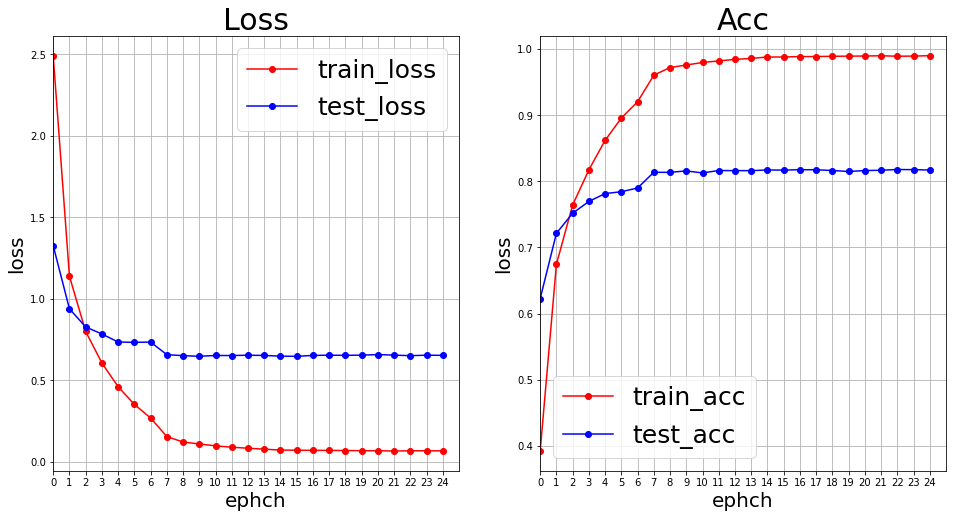

In [1]:
import matplotlib.pyplot as plt
train_Loss = [2.4924, 1.1386, 0.7998, 0.6060, 0.4606, 0.3519, 0.2684, 0.1544, 0.1213, 0.1091, 0.0974, 0.0892, 0.0829, 0.0772, 0.0715, 0.0708, 0.0699, 0.0696, 0.0689, 0.0675, 0.0676, 0.0657, 0.0672, 0.0674, 0.0668]
test_loss = [1.3262, 0.9389, 0.8272, 0.7841, 0.7349, 0.7328, 0.7344, 0.6574, 0.6510, 0.6474, 0.6521, 0.6518, 0.6539, 0.6524, 0.6481, 0.6471, 0.6525, 0.6540, 0.6530, 0.6543, 0.6578, 0.6545, 0.6510, 0.6540, 0.6530]
train_acc = [0.3920, 0.6746, 0.7642, 0.8174, 0.8620, 0.8958, 0.9204, 0.9606, 0.9722, 0.9760, 0.9798, 0.9822, 0.9845, 0.9860, 0.9881, 0.9881, 0.9888, 0.9888, 0.9892, 0.9894, 0.9896, 0.9900, 0.9893, 0.9895, 0.9901]
test_acc = [0.6226, 0.7214, 0.7518, 0.7696, 0.7815, 0.7843, 0.7899, 0.8137, 0.8136, 0.8158, 0.8127, 0.8164, 0.8162, 0.8162, 0.8172, 0.8170, 0.8176, 0.8175, 0.8164, 0.8149, 0.8163, 0.8168, 0.8179, 0.8177, 0.8171]
plt.figure(figsize=[16, 8])

plt.subplot(121)
plt.title(label = 'Loss', fontsize = 30)
plt.xlabel('ephch', fontsize = 20)
plt.ylabel('loss', fontsize = 20)
plt.plot(range(25), train_Loss, 'r-o', label = 'train_loss')
plt.plot(range(25), test_loss, 'b-o', label = 'test_loss')
plt.xlim((0, 25))
plt.xticks(range(25))
plt.legend(fontsize = 25)
plt.grid()


plt.subplot(122)
plt.title(label = 'Acc', fontsize = 30)
plt.xlabel('ephch', fontsize = 20)
plt.ylabel('loss', fontsize = 20)
plt.plot(range(25), train_acc, 'r-o', label = 'train_acc')
plt.plot(range(25), test_acc, 'b-o', label = 'test_acc')
plt.xlim((0, 25))
plt.xticks(range(25))
plt.legend(fontsize = 25)
plt.grid()

25